#### fraction for YM 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_excel("./Data/YM.xlsx", index_col = 0)
df1

,Co,Ni,Cr,Fe,Mn,YM
Index,,,,,,
0,0.025,0.900,0.025,0.025,0.025,139.73000
1,0.050,0.800,0.050,0.050,0.050,131.75000
2,0.075,0.700,0.075,0.075,0.075,120.51000
3,0.100,0.600,0.100,0.100,0.100,114.29000
4,0.125,0.500,0.125,0.125,0.125,103.38000
...,...,...,...,...,...,...
75,0.744,0.063,0.193,0.000,0.000,181.73482
76,0.765,0.057,0.178,0.000,0.000,185.34186
77,0.701,0.073,0.226,0.000,0.000,180.70507


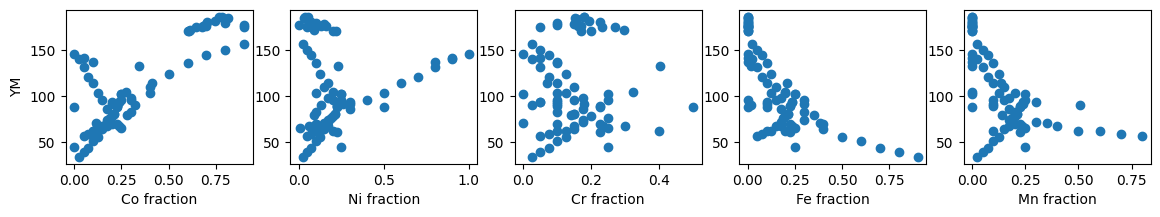

In [3]:
# visulaize the data
plt.figure(figsize=(14,2))

plt.subplot(1, 5, 1)
plt.scatter(df1['Co'], df1['YM'])
plt.xlabel('Co fraction')
plt.ylabel('YM')

plt.subplot(1, 5, 2)
plt.scatter(df1['Ni'], df1['YM'])
plt.xlabel('Ni fraction')

plt.subplot(1, 5, 3)
plt.scatter(df1['Cr'], df1['YM'])
plt.xlabel('Cr fraction')

plt.subplot(1, 5, 4)
plt.scatter(df1['Fe'], df1['YM'])
plt.xlabel('Fe fraction')

plt.subplot(1, 5, 5)
plt.scatter(df1['Mn'], df1['YM'])
plt.xlabel('Mn fraction')
plt.show()

In [4]:
df2 = pd.read_excel("./Data/CRSS.xlsx", index_col = 0)
df2
len(df2)

74

Text(0.5, 0, 'Mn')

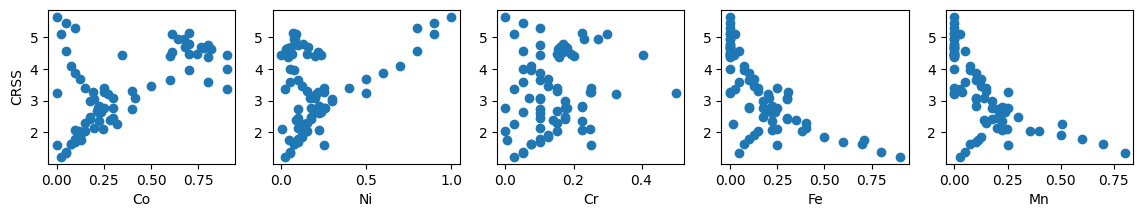

In [5]:
# visualize the data
plt.figure(figsize=(14,2))

plt.subplot(1, 5, 1)
plt.scatter(df2['Co'], df2['CRSS'])
plt.xlabel("Co")
plt.ylabel("CRSS")

plt.subplot(1, 5, 2)
plt.scatter(df2['Ni'], df2['CRSS'])
plt.xlabel("Ni")

plt.subplot(1, 5, 3)
plt.scatter(df2['Cr'], df2['CRSS'])
plt.xlabel("Cr")

plt.subplot(1, 5, 4)
plt.scatter(df2['Fe'], df2['CRSS'])
plt.xlabel("Fe")

plt.subplot(1, 5, 5)
plt.scatter(df2['Mn'], df2['CRSS'])
plt.xlabel("Mn")



#### add descriptors and build a database for training
radius, electronegativity, valence, youngs modulus, temperature, mix entropy, poisson ratio, cohesive energy, shear modulus

In [6]:
class databuild():
    def __init__(self, fraction):
        self.frac_list = fraction
        self.rad_list = [192, 163, 189, 194, 197] # radius, unit: [pm]
        self.chi_list = [1.88, 1.91, 1.83, 1.66, 1.55] # Electronegativity
        self.VEC_list = [9, 10, 6, 8, 7] # valence electron concentration (containing d orbital electrons)
        self.E_list = [209, 200, 279, 211, 198] # Young's modulus [GPa]
        self.T_list = [1768, 1455, 1907, 1538, 1246] # unit: [°C]
        self.H_list = [0, -4, -1, -5, -7, -2, -8, -1, 2, 0] # mix entropy
        self.mu_list = [0.320, 0.312, 0.210, 0.291, 0.24] # Poisson ratio
        self.Ec_list = [4.39, 4.44, 4.10, 4.13, 2.92] # cohesive energy
        self.G_list = [75, 76, 115, 82, 76.4] # shear modulus [GPa]

    def fraction(self):
        fraction = []
        for num in self.frac_list:
            numb = round((num / sum(self.frac_list)), 2)
            fraction.append(numb)
        return fraction
    
    def delta_r(self):
        r_mean = np.mean(self.rad_list)
        delta_r = 0
        for rad, frac in zip(self.rad_list, self.fraction()):
            delta_r += frac * (1 - rad/r_mean) ** 2
        return round(np.sqrt(delta_r) * 10, 2)

    def delta_chi(self):
        chi_mean = np.mean(self.chi_list) # the mean value of electronegativity
        delta_chi = 0
        for chi_ele, frac in zip(self.chi_list, self.fraction()):
            delta_chi += frac * (chi_ele - chi_mean) ** 2
        return round(np.sqrt(delta_chi) * 10, 2)

    def VEC(self):
        VEC = 0
        for VEC_e, frac in zip(self.VEC_list, self.fraction()):
            VEC += frac * VEC_e
        return round(VEC, 2)

    def delta_H(self):
        index, H = 0, 0
        for loopi in range(len(self.fraction())):
            for loopj in range(loopi + 1, len(self.fraction())):
                H += 4 * self.H_list[index] * self.fraction()[loopi] * self.fraction()[loopj]
                index += 1
        return round(H, 2)

    def delta_S(self):
        R, S = 8.3145, 0
        for frac in self.fraction():
            if frac == 0:
                S += 0
            else:
                S += frac * np.log(frac)
        return round(-1* R * S, 2)

    def omega(self):
        return round(np.mean(self.T_list) * (self.delta_S() / (np.abs(self.delta_H()) + 1e-8)) / 500, 2)

    def Lambda(self):
        return round(self.delta_S() / (self.delta_r() ** 2 + 1e-8), 2)

    def DX(self):
        DX = 0
        for loopi in range(len(self.fraction())):
            for loopj in range(loopi, len(self.fraction())):
                DX += self.fraction()[loopi] * self.fraction()[loopj] * np.abs(self.chi_list[loopi] - self.chi_list[loopj])
        return round(DX * 50, 2)

    def Ec(self):
        EC = 0
        for frac, Ec_ele in zip(self.fraction(), self.Ec_list):
            EC += frac * Ec_ele
        return round(EC, 2)
    
    def eta(self):
        G = self.G()
        eta = 0
        for frac, G_ele in zip(self.fraction(), self.G_list):
            eta += (frac * 2 * (G_ele - G) / (G_ele + G)) / \
            (1 + 0.5 * np.abs((frac * 2 * (G_ele - G) / (G_ele + G))))
        return round(eta, 2)

    def Dr(self):
        Dr = 0
        for loopi in range(len(self.fraction())):
            for loopj in range(loopi, len(self.fraction())):
                Dr += self.fraction()[loopi] * self.fraction()[loopj] * np.abs(self.rad_list[loopi] - self.rad_list[loopj])
        return round(Dr, 2)

    def A(self):
        mu = np.mean(self.mu_list)
        A = self.G() * self.delta_r() * (1 + mu) * (1 - mu)
        return round(A, 2)

    def F(self): 
        return round((2 * self.G()) / (1 - np.mean(self.mu_list)) / 10, 2)

    def G(self): 
        G = 0
        for frac, G_ele in zip(self.fraction(), self.G_list):
            G += frac * G_ele
        return round(G / 10, 2)

    def delta_G(self):
        G = self.G()
        delta_G = 0
        for frac, G_ele in zip(self.fraction(), self.G_list):
            delta_G += frac * (1 - G_ele / G) ** 2
        return round(np.sqrt(delta_G), 2)

    def DG(self):
        DG = 0
        for loopi in range(len(self.fraction())):
            for loopj in range(loopi, len(self.fraction())):
                DG += self.fraction()[loopi] * self.fraction()[loopj] * np.abs(self.G_list[loopi] -self.G_list[loopj])
        return round(DG, 2)

    def mu(self):
        mu = np.mean(self.E_list) * self.delta_r()
        return round(0.5 * mu / 10, 2)

    def descripters(self):
        des1 = np.array([self.delta_r(), self.delta_chi(), self.VEC(), self.delta_H(), 
                         self.delta_S(), self.omega(), self.Lambda(), self.DX(), 
                         self.Ec(), self.eta(), self.Dr(), self.A(), self.F(), self.G(), 
                         self.delta_G(), self.DG(), self.mu()])
        frac1 = self.fraction()
        return np.hstack([des1, frac1])

fraction = [1, 2, 3, 4, 5]
dat = databuild(fraction).descripters()
print(dat)

[ 0.59  1.51  7.6  -2.83 12.41 13.88 35.65  3.83  3.78  1.36  4.75  4.66
  2.36  8.55  9.17  6.8   6.47  0.07  0.13  0.2   0.27  0.33]


#### save YM data as csv file

In [7]:
YMdata = []
for i in range(len(df1)):
    fraction = [df1.iloc[i]['Co'], df1.iloc[i]['Ni'],df1.iloc[i]['Cr'],df1.iloc[i]['Fe'],df1.iloc[i]['Mn']]
    xdata = databuild(fraction).descripters()
    ydata = df1.iloc[i]['YM']
    xydata = np.hstack([xdata, ydata])
    YMdata.append(xydata)

YMdata = np.array(YMdata)
np.savetxt("./Data/YMdata.csv", YMdata, delimiter = ",")

#### save CRSS data as csv file

In [8]:
CRSSdata = []
for i in range(len(df2)):
    fraction = [df2.iloc[i]['Co'], df2.iloc[i]['Ni'],df2.iloc[i]['Cr'],df2.iloc[i]['Fe'],df2.iloc[i]['Mn']]
    xdata = databuild(fraction).descripters()
    ydata = df2.iloc[i]['CRSS']
    xydata = np.hstack([xdata, ydata])
    CRSSdata.append(xydata)
CRSSdata = np.array(CRSSdata)
np.savetxt("./Data/CRSSdata.csv", CRSSdata, delimiter = ",")